In [1]:
## packages

import librosa
import sklearn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

import os

import numpy as np
import pandas as pd

In [2]:
## testing with a file

audio_path = '../input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav'
x , sr = librosa.load(audio_path)
print(type(x), type(sr))

print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


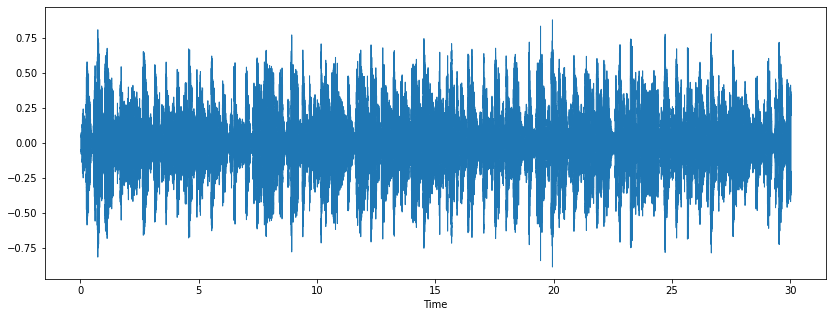

In [3]:
## ploting the file in waveform

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

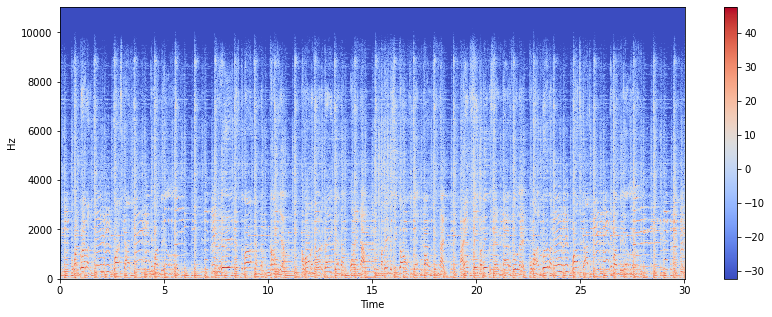

In [4]:
## converting the song into image using Spectrogram

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

### Feature Extraction

##### Zero crossig rate

The zero-crossing rate is the rate of sign-changes along with a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds like those in metal and rock.

16


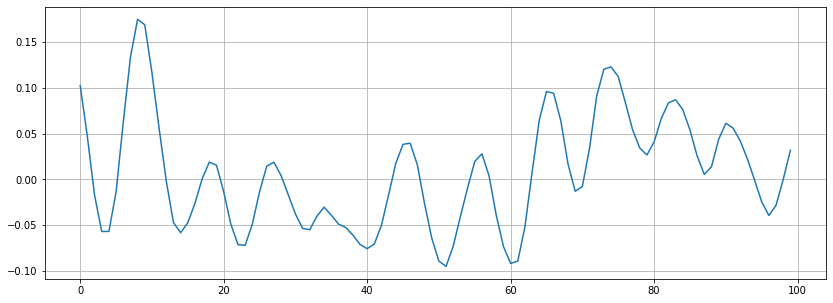

In [5]:


n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

##### Spectral Centroid
It indicates where the ” center of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. Consider two songs, one from a blues genre and the other belonging to metal. Now, as compared to the blues genre song, which is the same throughout its length, the metal song has more frequencies towards the end. So spectral centroid for blues song will lie somewhere near the middle of its spectrum while that for a metal song would be towards its end.

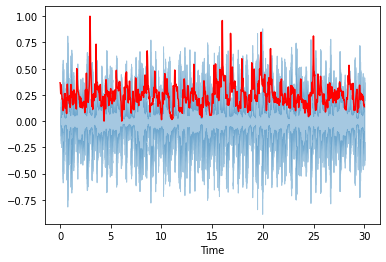

In [6]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

In [7]:
## include if all the genre is needed
# genre = os.listdir(path)
# print(genre)

genre = ['hiphop', 'pop']

In [8]:
## feature extraction funciton

def normalize(x, axis=0):
        return sklearn.preprocessing.minmax_scale(x, axis=axis)

def zero_cross(x):
    n0 = 9000
    n1 = 9100
    zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
    return sum(zero_crossings)

def spec_center(x, sr):
    spectral_centroids = normalize(librosa.feature.spectral_centroid(x, sr=sr)[0])
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    ma = max(spectral_centroids)
    return t[np.where(spectral_centroids==ma)[0][0]]

In [9]:
li = []
path = '../input/gtzan-dataset-music-genre-classification/Data/genres_original/'

for gen in genre:
    for song in os.listdir(os.path.join(path, gen)):
        x, sr = librosa.load(os.path.join(path, gen, song))
        li.append([zero_cross(x), round(spec_center(x, sr), 2), gen])

In [10]:
li = np.array(li)

### Implementing svm

In [11]:
X = li[:, 0:2]
y = li[:,2]

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [13]:
from sklearn.svm import SVC
classifier = SVC(kernel='rbf', random_state = 1)
classifier.fit(X_train,y_train)

SVC(random_state=1)

In [14]:
y_pred = classifier.predict(X_test)

In [15]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[ 6, 17],
       [ 3, 14]])

In [19]:
## testing for custom song
import joblib
joblib.dump(classifier, 'model.pkl')

pa = '../input/gtzan-dataset-music-genre-classification/Data/genres_original/hiphop/hiphop.00005.wav'
x, sr = librosa.load(pa)
print(classifier.predict(np.array([[zero_cross(x), round(spec_center(x, sr), 2)]])))

['pop']


In [17]:
## finding the best pair with more accuracy
from itertools import combinations
from sklearn.metrics import accuracy_score

def accuracy(genre):
    li = []
    for gen in genre:
        for song in os.listdir(os.path.join(path, gen)):
            x, sr = librosa.load(os.path.join(path, gen, song))
            li.append([zero_cross(x), round(spec_center(x, sr), 2), gen])
    li = np.array(li)
    X = li[:, 0:2]
    y = li[:,2]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    classifier = SVC(kernel='rbf', random_state = 1)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    return round(accuracy_score(y_test, y_pred), 2)

ge = ['blues', 'metal']
print(f"{ge[0]} vs {ge[1]} accu: {accuracy(ge)}")

blues vs metal accu: 0.85
